# Baseline Test Notabook on ML and DL for Audio sample to note

#### Base imports

In [4]:
import tensorflow
from keras import Sequential, Input,layers,models
import numpy as np
import pandas as pd
import librosa
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
from databass.utils import create_table

#### path imports

In [2]:
from pathlib import Path
import sys, os

# Find the repo root by walking up until we find 'utils'
repo_root = Path.cwd()
while not (repo_root / "utils").exists():
    if repo_root.parent == repo_root:
        raise RuntimeError("Cannot find repo root containing 'utils' from cwd: " + str(Path.cwd()))
    repo_root = repo_root.parent

# Prepend repo_root so `from utils...` works
sys.path.insert(0, str(repo_root))
print("Added to sys.path:", repo_root)

# Now import
from utils.create_table import create_table

Added to sys.path: /home/edgar/code/Arkyed/08-Project/databass-code/DataBass


In [ ]:
create_table()
table = pd.read_csv('table_correspondance_notes_basse.csv')

NameError: name 'create_table' is not defined

In [4]:
table.shape

NameError: name 'table' is not defined

In [ ]:
table['note'] = table['note'].str.strip().str.upper()
table

,corde,case,note,fréquence (Hz)
0,E,0,E1,41.20
1,E,1,F1,43.65
2,E,2,F♯1,46.25
3,E,3,G1,49.00
4,E,4,G♯1,51.91
...,...,...,...,...
95,G,20,D♯4,311.13
96,G,21,E4,329.63
97,G,22,F4,349.23
98,G,23,F♯4,370.00


In [6]:
from extract.bass_extract import extract_bass_list

In [8]:
WORKING_DIR = os.environ.get('WORKING_DIR')
extract_bass_list(WORKING_DIR)
chorus_bass_list = pd.read_csv(f'{WORKING_DIR}/data/preprocessed/chorus_bass_list.csv')
chorus_bass_list.sample()
chorus_bass_list['note_name'] = chorus_bass_list['note_name'].str.strip().str.upper()

Processing effect: Phaser
Extracted bass list for effect Phaser saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/Phaser_list.csv
Processing effect: EQ
Extracted bass list for effect EQ saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/EQ_list.csv
Processing effect: Overdrive
Extracted bass list for effect Overdrive saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/Overdrive_list.csv
Processing effect: Flanger
Extracted bass list for effect Flanger saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/Flanger_list.csv
Processing effect: Chorus
Extracted bass list for effect Chorus saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/Chorus_list.csv
Processing effect: SlapbackDelay
Extracted bass list for effect SlapbackDelay saved to /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/data/preprocessed/SlapbackDela

In [9]:
chorus_bass_list.shape

(1872, 13)

In [10]:
merged_data = chorus_bass_list.merge(table[['fréquence (Hz)','note']], left_on='note_name',right_on='note',how='left').drop('note',axis=1)
merged_data.head(10)
merged_data.drop_duplicates(inplace=True)
merged_data.shape

NameError: name 'table' is not defined

In [11]:
merged_data['file_path'][0]

NameError: name 'merged_data' is not defined

In [ ]:
len(merged_data['note_name'].unique())

28

In [12]:
length_before = 1000
length_after = 5000

In [13]:
def select_starting_point(y, length_before=1000, length_after=5000):
    start_ind = 0
    for i in range(len(y)):
        if y[i] >= 0.9 * y.max():
            start_ind = i
            break

    y_select = y[start_ind-length_before:start_ind+length_after].copy()
    return y_select


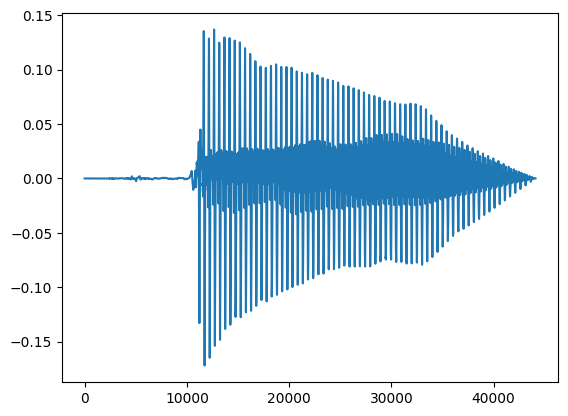

In [14]:
wave1, sr1 = librosa.load(WORKING_DIR + '/raw_data/' + chorus_bass_list['file_path'][1])
plt.plot(wave1)


array([-0.00764912, -0.00744178, -0.00722447, ..., -0.00588334,
       -0.00475456, -0.00371673], shape=(6000,), dtype=float32)

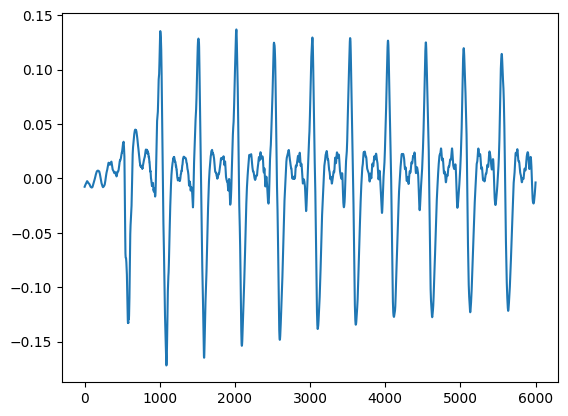

In [15]:
wave1_select = select_starting_point(wave1)
plt.plot(wave1_select)
wave1_select

In [17]:
import numpy as np
import librosa

def load_and_truncate(path, sr=22050):
    """
    Load audio file, resample, and pad/truncate to fixed length.

    Args:
        path (str): Path to audio file
        sr (int): Target sample rate (default 22050 Hz)
        max_len (int): Desired length in samples (default 5 seconds)

    Returns:
        np.ndarray: 1D array of length max_len
    """
    y, _ = librosa.load(path, sr=sr,dtype=np.float32)  # load audio
    #detect starting point of note
    y_select = select_starting_point(y)
    return y_select

In [18]:
sample_type = load_and_truncate('Sample.wav')
print(sample_type.dtype, type(sample_type))

float32 <class 'numpy.ndarray'>


In [20]:
X = chorus_bass_list['file_path'].apply(lambda x : load_and_truncate(WORKING_DIR + '/raw_data/' + x))
y = chorus_bass_list['note_name']

In [21]:
len(X), X.shape, X.dtype, X[0].dtype, X[0].shape, type(X[0])

(1872, (1872,), dtype('O'), dtype('float32'), (6000,), numpy.ndarray)

In [22]:
print(type(X))
if hasattr(X, "dtype"):
    print(X.dtype)
else:
    print("Pas de dtype")

<class 'pandas.core.series.Series'>
object


In [23]:
X = np.stack(X).astype(np.float32)
X.shape

(1872, 6000)

In [24]:
classes = len(y.unique())
classes

28

#### encode y labels aka Notes

In [25]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
y_int = le.fit_transform(chorus_bass_list['note_name'])  # integers 0..n_classes-1
y = to_categorical(y_int)

In [ ]:
categories = y.shape[1]

X shape: (1872, 6000), X type : <class 'numpy.ndarray'> ,X[0].shape: (6000,), X[0] type : float32, y shape: (1872, 28)
Example X[0] length: 6000, y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


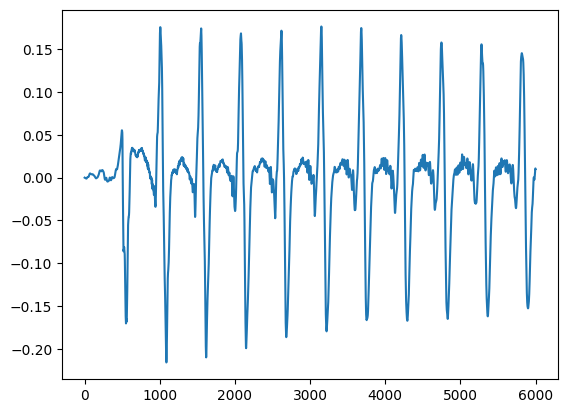

In [ ]:
print(f'X shape: {X.shape}, X type : {type(X)} ,X[0].shape: {X[0].shape}, X[0] type : {X[0].dtype}, y shape: {y.shape}')
print(f'Example X[0] length: {len(X[0])}, y[0]: {y[0]}')
plt.plot(X[0])

In [ ]:
"""
Preprocess of features, not sure yet what it does.

X_features = chorus_bass_list['file_path'].apply(
    lambda x: librosa.feature.mfcc(
        y=librosa.load(WORKING_DIR + '/raw_data/' + x)[0],
        sr=librosa.load(WORKING_DIR + '/raw_data/' + x)[1],
        n_mfcc=13
    ).mean(axis=1)  # average over time → fixed-length vector
)

X = np.vstack(X_features.values).astype(np.float32)
"""

"\nPreprocess of features, not sure yet what it does.\n\nX_features = chorus_bass_list['file_path'].apply(\n    lambda x: librosa.feature.mfcc(\n        y=librosa.load(WORKING_DIR + '/raw_data/' + x)[0],\n        sr=librosa.load(WORKING_DIR + '/raw_data/' + x)[1],\n        n_mfcc=13\n    ).mean(axis=1)  # average over time → fixed-length vector\n)\n\nX = np.vstack(X_features.values).astype(np.float32)\n"

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [27]:
unique_notes = len(table.note.unique())
unique_notes

NameError: name 'table' is not defined

In [28]:
print(len(X[0]),len(y[0]),X[0].shape)
print(len(X_train[0]), len(y_train[0]) , X[0].shape)

6000 28 (6000,)
6000 28 (6000,)


In [29]:
input_shape = (X[0].shape[0],1)
input_shape

(6000, 1)

# Dense neural Network model

In [ ]:
## create dense model and compile dense model :
def make_model(input_shape):
    input_layer = layers.Input(shape=input_shape)

    conv1 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)

    gap = layers.GlobalAveragePooling1D()(conv3)

    output_layer = layers.Dense(categories, activation="softmax")(gap)

    return models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape)

E0000 00:00:1765296601.727069   38175 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765296601.739601   38175 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 6000, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 6000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6000, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 6000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6000, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 6000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,548 (107.61 KB)

 Trainable params: 27,164 (106.11 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
print(type(X_train))
print(X_train.dtype if hasattr(X_train, "dtype") else "no dtype")
print(type(y_train))
print(y_train.dtype if hasattr(y_train, "dtype") else "no dtype")

<class 'numpy.ndarray'>
float32
<class 'numpy.ndarray'>
float64


Dense NN commented, it's only 0.10 accuracy.

In [ ]:
"""
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es])
"""

In [ ]:
print(f'{round(max(history.history['accuracy']),4)} is our best accuracy on training data with a Conv1D model')

In [ ]:
results = model.evaluate(X_test, y_test)
print(f'{round(results[1],4)} is our accuracy on test data with a Conv1D model')

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.0605 - loss: 3.3054
0.06 is our accuracy on test data with a Conv1D model


### test with a random forest

In [30]:
from sklearn.model_selection import cross_validate

In [ ]:
# create a randomforest model to try and output the note based on the audio file
rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=None,random_state=42)

np.float64(0.8045801526717558)

In [ ]:
results = cross_validate(rf_classifier, X_train, y_train, cv=10,scoring='accuracy')
results['test_score'].mean()

In [ ]:
rf_classifier.fit(X_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
rf_classifier.score(X_test,y_test)

0.8149466192170819

In [34]:
"""
Snippet pour entraîner et sélectionner le meilleur modèle parmi plusieurs régressions avec GridSearchCV.

Ce code définit :
- Un dictionnaire de modèles (GradientBoosting, RandomForest, LinearRegression, DecisionTree, SVR, AdaBoost, XGBRegressor).
- Un dictionnaire d'hyperparamètres associés.
- Une boucle itérative qui entraîne chaque modèle avec GridSearchCV et conserve le meilleur.
"""
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# dictionary of model to search on
models = {
    'model_gbm': GradientBoostingClassifier(),
    'model_rf': RandomForestClassifier(),
    'model_lr': LogisticRegression(),
    'model_dt': DecisionTreeClassifier(),
    'model_svc': SVC(),
    'model_ada': AdaBoostClassifier(),
    'model_xgb': XGBClassifier()
}

# dictionary of hyperparameters
params = {
    'model_gbm': {'model__learning_rate':[0.1,0.2,0.3,0.4], 'model__n_estimators':[50,100,500,1000,2000], 'model__max_depth':[3,5,7]},
    'model_rf': {'model__n_estimators':[50,100,500,1000,2000], 'model__max_depth':[2,5,7,10,20]},
    'model_dt': {'model__splitter':['best','random'], 'model__max_depth':[2,5,7,10,20,50]},
    'model_svm': {'model__C':[1,2,5,10,50,100,500], 'model__kernel':['rbf','poly','sigmoid','linear'], 'model__degree':[2,3,4], 'model__gamma':['scale','auto']},
    'model_ada': {'model__n_estimators':[10,20,30,50,100,500,1000], 'model__learning_rate':[0.5,1,2,5,10]},
    'model_xgb': {'model__n_estimators':[50,100,500,1000], 'model__learning_rate':[0.01,0.05,0.1,0.2], 'model__max_depth':[3,5,7,10]}
}

# initialize a dictionary
best_models = {}

# iterating loops through models and params
for name, model in models.items():
    print(f"Training and tuning {name}...")
    final_pipe = Pipeline([
        ('model', model)
    ])
    grid = params.get(name, {})
    search = GridSearchCV(final_pipe, grid, scoring='accuracy', cv=5, n_jobs=-1)
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"{name}: Best params -> {search.best_params_}, Score -> {search.best_score_}")

Training and tuning model_gbm...


ValueError: 
All the 300 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 669, in fit
    y = self._encode_y(y=y, sample_weight=None)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 1519, in _encode_y
    encoded_y_int = label_encoder.fit_transform(y)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/preprocessing/_label.py", line 110, in fit_transform
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1483, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (1048, 28) instead.


## RandomwSearch RandomForest

In [37]:
#grid search the random forest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

rf_classifier = RandomForestClassifier(random_state=42)

# Définir une grille d'hyperparamètres
param_grid = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(0,5),
    'min_samples_split': randint(2,11),
    'min_samples_leaf': randint(1,11),
    'min_impurity_decrease': uniform(0.0, 0.5),
}

# Recherche par grille
grid_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
  File "/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/sklearn/base.py", line 471, in _validate_pa

Meilleurs paramètres : {'max_depth': 3, 'min_impurity_decrease': np.float64(0.24179884722812117), 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 186}


In [39]:
best_forest = grid_search.best_estimator_
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': np.float64(0.24179884722812117),
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 186,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
best_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': np.float64(0.24179884722812117),
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 186,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

best_forest = RandomForestClassifier(
    n_estimators=186,
    min_samples_leaf=5,
    min_samples_split=10,
    max_depth=3,
    min_impurity_decrease=0.24179884722812117
)
best_forest.fit(X_train,y_train)